# Description
This script compares cest values of regions within network vs between network.


## Import Packages

In [59]:
import os
import glob
import numpy as np
import pandas as pd
#import network_fcon as fc
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
import numpy as np

### Set Variables and Paths

In [71]:
# Set Variables
fieldstrength = '3T'
atlas = 'S1000'
bblids = []
sesids = []
nmaps = ["NMDA", "mGluR5", "GABA","D2"]
diag_scores = ["dx_pscat", "hstatus","sex", "age", "race","ethnic"] # ,"axis1_desc1","axis1_stat1"
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
#subjlist = subjlist[subjlist['fieldstrength'] == fieldstrength]
#subjs = subjlist['BBLID']

# Import group dataframes and set indices
#subjlist = pd.read_csv(path + "data/pipeline_input_all_subj.csv", sep=',') 
cestmat = pd.read_csv("filtered_cest_parcelmat" + fieldstrength + atlas + ".csv", sep=',') 
fcmat = pd.read_csv("fc_parcelmat_" + fieldstrength + atlas + ".csv", sep=',')
rehomat = pd.read_csv("reho_parcelmat" + fieldstrength + atlas + ".csv", sep=',')
grp_df = pd.read_csv("filtered_grp_df" + fieldstrength + atlas + ".csv", sep=',')

# Reformat some dfs
cestmat.set_index('BBLID', inplace = True)
fcmat.set_index('BBLID', inplace = True)
rehomat.set_index('BBLID', inplace = True)
grp_df.set_index('BBLID', inplace = True)



        Unnamed: 0  Session dx_pscat hstatus  sex   age  race  ethnic  \
BBLID                                                                   
20303            0    12276  noDSMdx      NC  1.0  19.2   1.0     2.0   
90217            1    12064      pro     PRO  2.0  25.0   1.0     2.0   
88608            2  motive2      psy     PRO  1.0  25.4   2.0     2.0   
21874            3    12043      NaN     PSY  2.0  24.1   1.0     2.0   
94288            4    11948  noDSMdx      NC  1.0  22.7   1.0     2.0   
...            ...      ...      ...     ...  ...   ...   ...     ...   
135085          81  motive1      pro     PRO  2.0  18.9   1.0     2.0   
135277          82    12277      psy     PSY  2.0  30.2   2.0     2.0   
117397          83    10582    other    PROR  1.0  20.2   2.0     2.0   
87646           84    10496      NaN     NaN  NaN   NaN   NaN     NaN   
93242           85    12525    other    PROR  1.0  25.3   1.0     2.0   

        NZMean_502  NZcount_502  ...  reho_945  re

### Create functions

In [61]:
def filter(df, filter_list):
    filtered_columns = [col for col in df.columns if not any(substring in col for substring in filter_list)]
    return df[filtered_columns]

def keep(df, keep_list):
    keep_columns = [col for col in df.columns if any(substring in col for substring in keep_list)]
    return df[keep_columns]   

def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            valid_data = df[[col,col2]].dropna()
            if not valid_data.empty:
                _ , p = pearsonr(valid_data[col],valid_data[col2])
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
            else:
                p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = np.nan
    return p_matrix

### Create correlation matrix and heatmap

In [75]:
# Filter df to exclude subj info
subj_info = ["BBLID"] + ["Session"] + diag_scores + ["count"]
heat_df = filter(grp_df, subj_info)
corr_df=heat_df.corr()


### Correlation matrix after masking out the significant ones

            NZMean_502  NZMean_504  NZMean_518  NZMean_521  NZMean_532  \
NZMean_502    1.000000    0.609034    0.595836    0.673712    0.815907   
NZMean_504    0.609034    1.000000    0.576008    0.400149    0.718538   
NZMean_518    0.595836    0.576008    1.000000    0.715945    0.557033   
NZMean_521    0.673712    0.400149    0.715945    1.000000    0.524165   
NZMean_532    0.815907    0.718538    0.557033    0.524165    1.000000   
...                ...         ...         ...         ...         ...   
NZMean_959    0.093955   -0.013520    0.126532    0.118493    0.064487   
NZMean_961    0.277400    0.016835    0.001481    0.069328    0.264570   
NZMean_962    0.330356    0.066781    0.073837    0.121378    0.408660   
NZMean_973    0.123059   -0.137381   -0.097296    0.109380    0.177299   
NZMean_974    0.070510    0.143457    0.031036    0.199519    0.107333   

            NZMean_540  NZMean_542  NZMean_544  NZMean_545  NZMean_552  ...  \
NZMean_502    0.524377    0.7322

/Users/pecsok/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/pecsok/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1100x900 with 0 Axes>

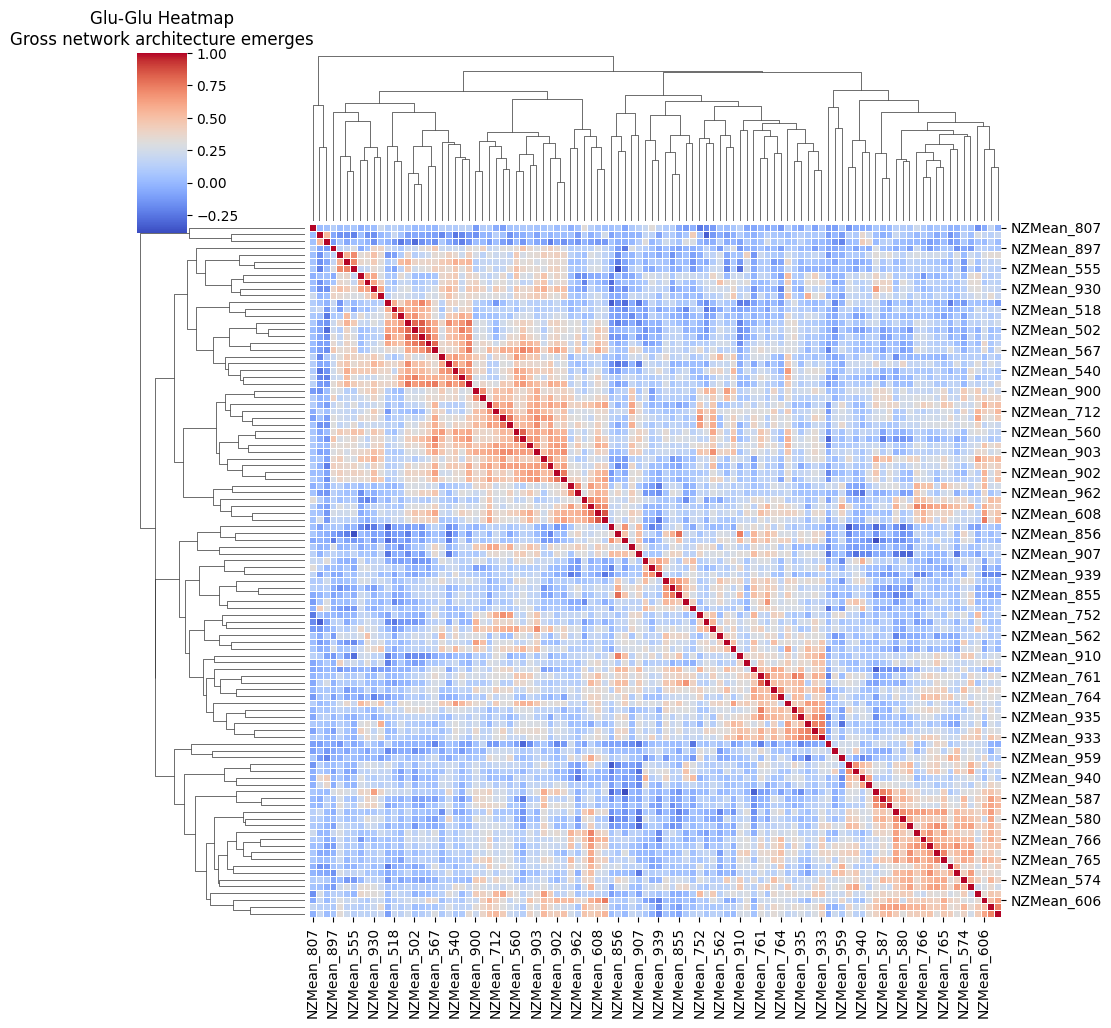

In [66]:
# Correlation matrix GluCEST-GluCEST
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
print(cestcorr_df.shape)
plt.figure(figsize=(11,9))
sns.clustermap(cestcorr_df, annot=False, cmap='coolwarm',linewidth=0.7)
plt.title('Glu-Glu Heatmap\nGross network architecture emerges')
#plt.tick_params(axis='both', which='major', labelsize=10)
plt.savefig('figures/' + atlas + '/Glu-Glu-Heatmap_hierarchical.png', dpi=300, bbox_inches='tight')
plt.show()


(102, 102)


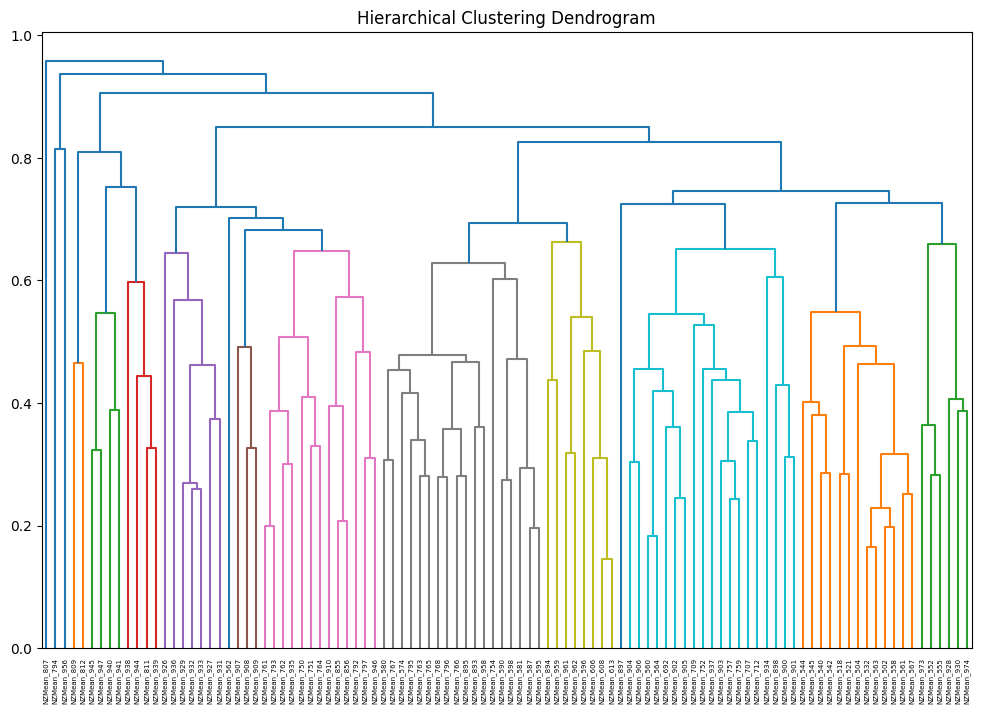

/Users/pecsok/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/pecsok/.local/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


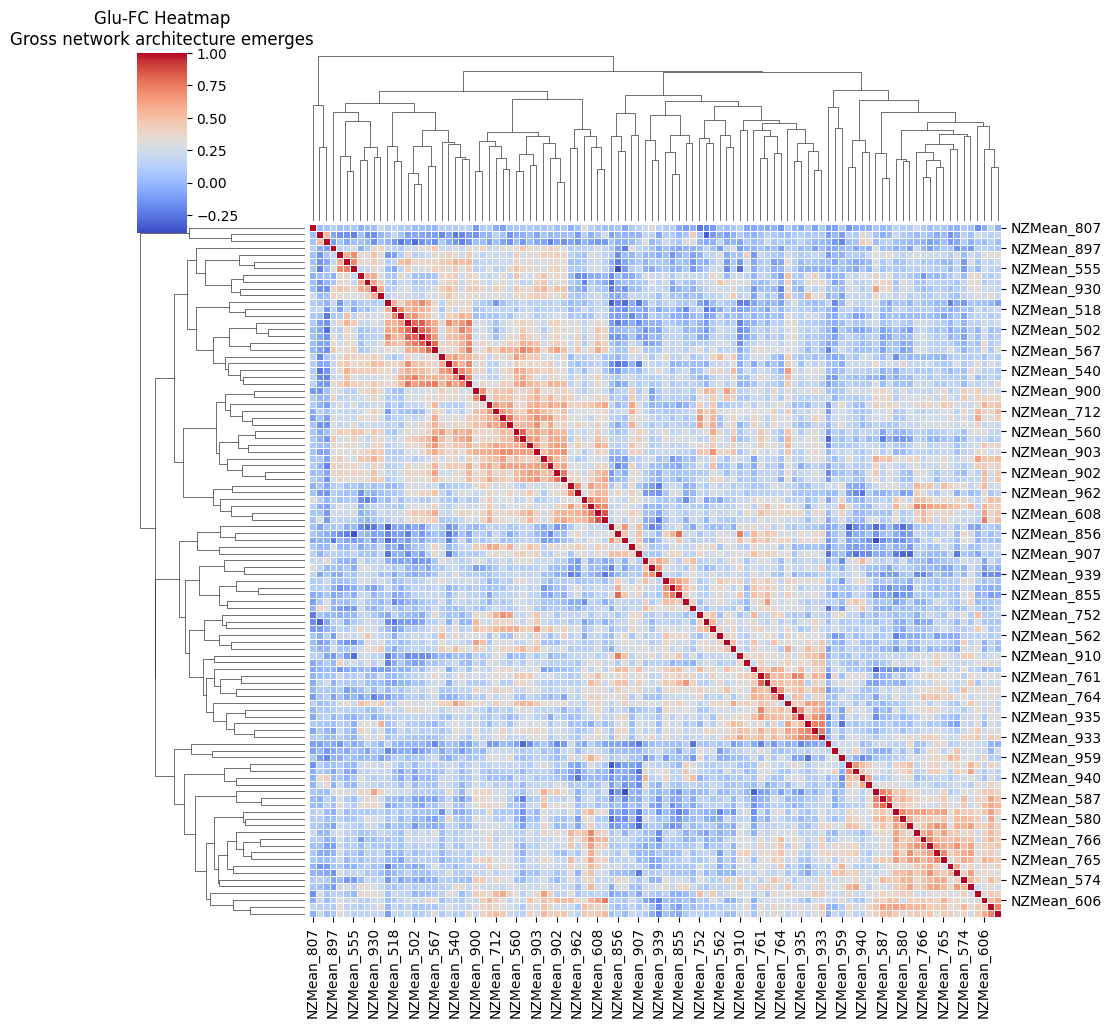

Item NZMean_502: Cluster 12
Item NZMean_504: Cluster 12
Item NZMean_518: Cluster 12
Item NZMean_521: Cluster 12
Item NZMean_532: Cluster 12
Item NZMean_540: Cluster 12
Item NZMean_542: Cluster 12
Item NZMean_544: Cluster 12
Item NZMean_545: Cluster 12
Item NZMean_552: Cluster 13
Item NZMean_555: Cluster 13
Item NZMean_558: Cluster 12
Item NZMean_560: Cluster 10
Item NZMean_561: Cluster 12
Item NZMean_562: Cluster 8
Item NZMean_563: Cluster 12
Item NZMean_564: Cluster 10
Item NZMean_567: Cluster 12
Item NZMean_574: Cluster 9
Item NZMean_580: Cluster 9
Item NZMean_581: Cluster 9
Item NZMean_587: Cluster 9
Item NZMean_590: Cluster 9
Item NZMean_595: Cluster 9
Item NZMean_596: Cluster 9
Item NZMean_598: Cluster 9
Item NZMean_606: Cluster 9
Item NZMean_608: Cluster 9
Item NZMean_613: Cluster 9
Item NZMean_692: Cluster 10
Item NZMean_707: Cluster 10
Item NZMean_709: Cluster 10
Item NZMean_712: Cluster 10
Item NZMean_750: Cluster 7
Item NZMean_751: Cluster 7
Item NZMean_752: Cluster 10
Item N

In [63]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# Assuming cestcorr_df is already defined as your correlation matrix
# The existing code you have:
cestcorr_df = corr_df.filter(like="NZ", axis=0).filter(like="NZ", axis=1)
print(cestcorr_df.shape)

# Convert the correlation matrix into a distance matrix
distance_matrix = 1 - cestcorr_df

# Perform hierarchical clustering
linked = linkage(squareform(distance_matrix), method='average')

# Determine clusters using a threshold distance
threshold = 0.7  # You can adjust this threshold depending on how strict you want to be
clusters = fcluster(linked, threshold, criterion='distance')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linked, labels=cestcorr_df.index)
plt.title('Hierarchical Clustering Dendrogram')
plt.savefig('figures/' + atlas + '/Glu-Glu-hierarchical_clusters_dendogram.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot the clustermap with the identified clusters
g = sns.clustermap(cestcorr_df, row_cluster=True, col_cluster=True, cmap='coolwarm', linewidth=0.7, method='average')
plt.title('Glu-FC Heatmap\nGross network architecture emerges')

# You can add cluster labels to the heatmap if needed
for idx, label in enumerate(g.ax_heatmap.get_yticklabels()):
    label.set_text(f'{label.get_text()} (Cluster {clusters[idx]})')
plt.show()

# Display the clusters
for i, cluster_id in enumerate(clusters):
    print(f'Item {cestcorr_df.index[i]}: Cluster {cluster_id}')

### PCA + tSNE

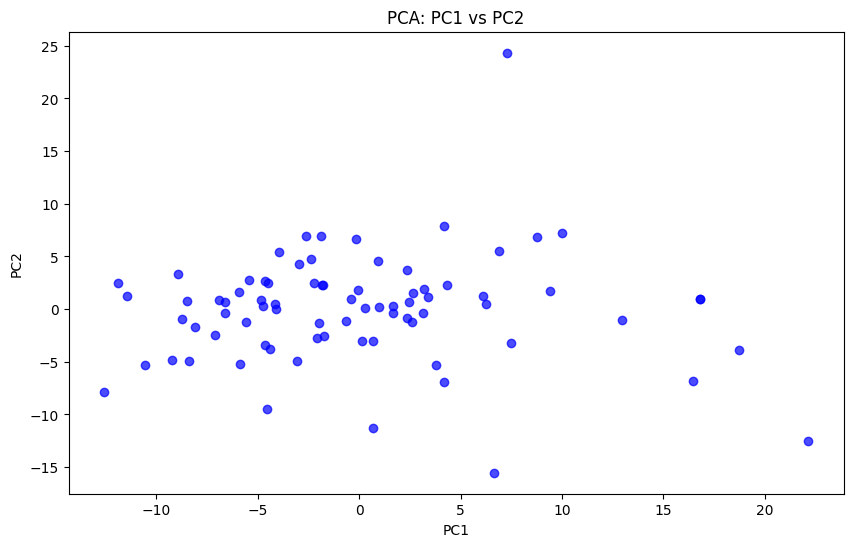

In [95]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

# Filter cest_df by excluding subjects missing > 1/3 of parcels.
cest_df = grp_df.filter(like="Mean")
filtered_df = cest_df[cest_df.isna().sum(axis=1) <= 33]
#cest_df = cest_df[nan_counts < 33]
#print(filtered_df)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(filtered_df), columns=filtered_df.columns, index=filtered_df.index)

pca = PCA(n_components=2)  # Adjust the number of components as needed
pca_result = pca.fit_transform(df_imputed)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])


# Plot the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='blue', alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: PC1 vs PC2')
plt.show()

In [93]:
# Step 2: Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df)

# Store t-SNE results in a DataFrame
df_tsne = pd.DataFrame(data=tsne_result, columns=['t-SNE1', 't-SNE2'])

# Step 3: Plot the t-SNE results, color-coded by PC1 and PC2
plt.figure(figsize=(10, 6))
plt.scatter(df_tsne['t-SNE1'], df_tsne['t-SNE2'], c=df_pca['PC1'], cmap='viridis')
plt.colorbar(label='PC1')
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.title('t-SNE Visualization Colored by PC1')
plt.show()

ValueError: Input X contains NaN.
TSNE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

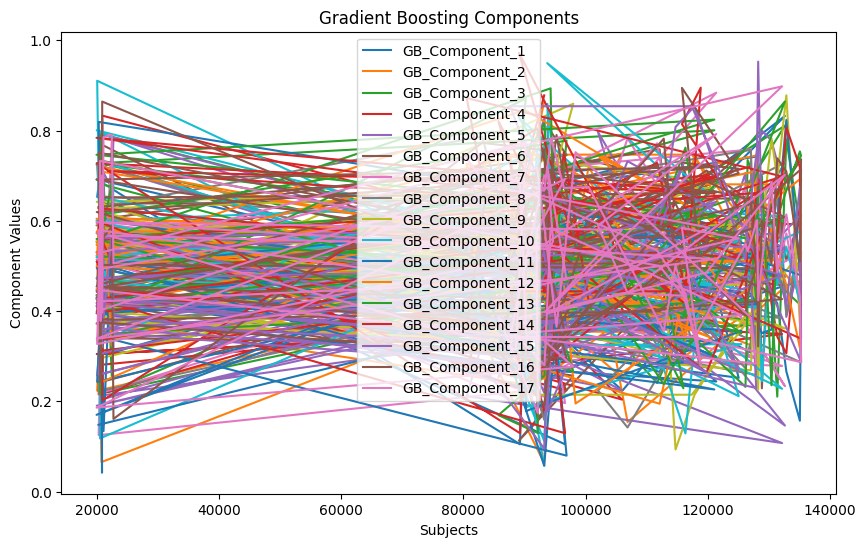

KeyboardInterrupt: 

In [64]:
def generate_gradients(input_df, n_components=17, random_state=42):
    """
    Generates gradients (components) from an input DataFrame (subjects x parcels) using HistGradientBoostingRegressor.
    
    Parameters:
    input_df (DataFrame): DataFrame with subjects as rows and parcels as columns.
    n_components (int): Number of components (gradients) to extract.
    random_state (int): Random seed for reproducibility.

    Returns:
    gb_components (DataFrame): DataFrame containing the generated gradients.
    feature_importances (DataFrame): Feature importance (parcel contribution) for each gradient.
    """
    
    # Set random seed for reproducibility
    np.random.seed(random_state)
    
    # Prepare the input DataFrame
    df = input_df.copy()
    
    # Create an empty DataFrame to store the estimated gradients
    gb_components = pd.DataFrame(index=df.index)

    # Loop through and fit models to estimate each gradient component
    for i in range(n_components):
        # Initialize the model
        regressor = HistGradientBoostingRegressor(random_state=random_state)

        # Use cross_val_predict to generate component estimates while preventing overfitting
        random_target = np.random.rand(len(df))  # Random target for unsupervised prediction
        gb_component = cross_val_predict(regressor, df, random_target, cv=5)

        # Store the resulting gradient (component)
        gb_components[f'GB_Component_{i+1}'] = gb_component

    # Plot the component values to see how they vary across subjects
    plt.figure(figsize=(10, 6))
    plt.plot(gb_components)
    plt.xlabel('Subjects')
    plt.ylabel('Component Values')
    plt.title('Gradient Boosting Components')
    plt.legend(gb_components.columns)
    plt.show()

   # Extract feature importances for each gradient component using permutation importance
    feature_importances = pd.DataFrame(index=df.columns)

    for i in range(n_components):
        regressor = HistGradientBoostingRegressor(random_state=random_state)
        regressor.fit(df, gb_components[f'GB_Component_{i+1}'])

        # Compute permutation importances
        result = permutation_importance(regressor, df, gb_components[f'GB_Component_{i+1}'], n_repeats=10, random_state=random_state)
        feature_importances[f'GB_Component_{i+1}'] = result.importances_mean
        
    # Display feature importances (parcel contributions)
    print("Feature Importances (Parcel Contributions):")
    print(feature_importances)

    # Rank Parcels by Importance for the First Component (Component 1)
    important_parcels = feature_importances['GB_Component_1'].sort_values(ascending=False)

    # Display the top parcels contributing to Component 1
    print("\nTop parcels contributing to Component 1:")
    print(important_parcels.head(10))  # Adjust the number to see more or fewer parcels

    # Plot feature importances for Component 1
    plt.figure(figsize=(10, 6))
    important_parcels.head(10).plot(kind='bar')
    plt.title('Top Parcel Contributions to GB_Component_1')
    plt.xlabel('Parcels')
    plt.ylabel('Feature Importance')
    plt.show()

    # Visualize the correlation matrix of the generated components
    plt.figure(figsize=(8, 6))
    sns.heatmap(gb_components.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Gradient Boosting Components')
    plt.show()

    return gb_components, feature_importances, important_parcels.head(10)


generate_gradients(cestmat.filter(like="NZMean",axis=1))
 